## Download data from ECDE and storing to greenmonkey

## (1) Reading libaries

In [49]:
## reading libaries:
import os
import requests
import zipfile

import json
from bs4 import BeautifulSoup

############ reading own fucntion - stored under ../src:
import src 
from src import working_with_netcdf                 # Option 1: all functions inside the working_with_netcdf.py file can now be usesd!
from src.working_with_netcdf import export_to_csv  # Option 2: only one functions inside the working_with_netcdf.py file can now be usesd!
from src import constants

###########################################################
import sqlalchemy as sa

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

print ("libaries are ready to use")

libaries are ready to use


set up API- config file on CWS:


- check your api: https://cds.climate.copernicus.eu/profile
- for the test stack check under: https://cds-test-cci2.copernicus-climate.eu/how-to-api

In [50]:
# import os



# #https://ecmwf.github.io/ecmwf-datastores-client/README.html#installation
# #$ conda install -c conda-forge ecmwf-datastores-client

# # Define the content of the configuration file
# # infos found : https://cds-test-cci2.copernicus-climate.eu/profile
# config_content = """
# url: https://cds-test-cci2.copernicus-climate.eu/api
# key: 09a0326a-629c-428a-b4d9-7d1a32e07b3c
# """

# # Define the path to the configuration file
# config_path = os.path.expanduser("~/.ecmwfdatastoresrc")

# # Write the configuration content to the file
# with open(config_path, 'w') as config_file:
#     config_file.write(config_content)

# print(f"Configuration file created at {config_path}")

In [51]:
#safe CDS API key version, can share or commit the script without leaking credentials 

import os
from src import configEvaECDEAPI  # your file with CDS_KEY

config_content = f"""\
url: {configEvaECDEAPI.CDS_URL}
key: {configEvaECDEAPI.CDS_KEY}
"""

config_path = os.path.expanduser(r"C:\Users\ivits\.cdsapirc")

with open(config_path, "w") as f:
    f.write(config_content)

print(f".cdsapirc updated at: {config_path}")





.cdsapirc updated at: C:\Users\ivits\.cdsapirc


In [52]:
#https://ecmwf.github.io/ecmwf-datastores-client/


from ecmwf.datastores import Client
client = Client()
client.check_authentication()  # optional check

[2025-09-30T00:00:00Z] This is an experimental and unsupported instance of the data store, not to be used in a production environment. For production environment go to [here](https://cds.climate.copernicus.eu/).
[2024-06-16T00:00:00Z] **BETA version** of the new CDS. Your [feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is very useful for us. **Please notice** that access to the system might suffer some disruptions due to evolving updates.
[2024-06-16T00:00:00Z] Check our [informative page](https://confluence.ecmwf.int/x/uINmFw) to best prepare yourself to use CDS-Beta.
[2024-06-16T00:00:00Z] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


{'id': 546,
 'sub': '755c6b6a-9b83-47e1-b748-2ddc23929e0b',
 'role': None,
 'email': 'eva.ivits@eea.europa.eu'}

In [53]:
collections = client.get_collections(sortby="update")

collection_ids = []
while collections is not None:  # Loop over pages
    collection_ids.extend(collections.collection_ids)
    collections = collections.next  # Move to the next page

## (2) Downloading the data (new appraocht)

In [54]:


dataset = "sis-ecde-aggregated-climate-indicators"
request = {
    "origin": "projections",
    "temporal_aggregation": ["yearly"],
    "spatial_aggregation": "regional_layer",
    "regional_layer": ["nuts_level_2"],
    "variable": ["mean_temperature"],
    "product": ["average"]
}

# Output folder
base_folder = r"\\cwsfileserver\projects\Climate\Preparedness_2026\f02_data\ECDE"
os.makedirs(base_folder, exist_ok=True)

# Extract variable name
variable = request["variable"][0]

# Create subfolder
out_folder = os.path.join(base_folder, variable)
os.makedirs(out_folder, exist_ok=True)

# Build zip path
zip_path = os.path.join(out_folder, f"{variable}.zip")

# Download data
client.retrieve(dataset, request, target=zip_path)

print(f"Downloaded ZIP: {zip_path}")

# Extract .nc files and delete zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(out_folder)

os.remove(zip_path)
print(f"Extracted and removed ZIP. Files are in: {out_folder}")


dc3d7e35d53d4c24740f912a9451ce5d.zip:   0%|          | 0.00/50.3k [00:00<?, ?B/s]

Downloaded ZIP: \\cwsfileserver\projects\Climate\Preparedness_2026\f02_data\ECDE\mean_temperature\mean_temperature.zip
Extracted and removed ZIP. Files are in: \\cwsfileserver\projects\Climate\Preparedness_2026\f02_data\ECDE\mean_temperature


In [47]:
print(zip_path)

\\cwsfileserver\projects\Climate\Preparedness_2026\f02_data\ECDE\mean_temperature\mean_temperature.zip


## (3) Downloading the data (old appraocht)

### (2.1) collect indicator information

In [4]:
## Read the json File -with indicator information  - stored : "..\..\..\data\ecde\ECDE_indicators.json"


# Define the path to your JSON file
file_path = "..\..\..\data\ecde\ECDE_indicators.json"

# Open and load the JSON data
with open(file_path, "r") as file:
    data = json.load(file)

# Now `data` is a dictionary containing the JSON data

print ("Hi ho - Please select one of the indicators for download:")
print ("--------------------------------")
for element in data:
    print (element)
#print(data)
print ("--------------------------------")

Hi ho - Please select one of the indicators for download:
--------------------------------
01_mean_temperature
02_growing_degree_days
03_heating_degree_days
04_cooling_degree_days
05_tropical_nights
06_hot_days
07_warmest_three_day_period
08_heat_waves_health
09_heat_waves_climatological
10_high_utci_days
11_frost_days
12_total_precipitation
13_maximum_five_days_precipitation
14_extreme_precipitation_total
15_frequency_of_extreme_precipitation
16_flood_recurrence_regridded
16b_mean_river_discharge_regridded
17_aridity_actual
18_consecutive_dry_days
19_duration_of_meteorological_droughts
20_magnitude_of_meteorological_droughts
21b_mean_soil_moisture
22_days_with_high_fire_danger
23_mean_wind_speed
24_extreme_wind_speed_days
25_snowfall_amount
26_period_with_snow_water_equivalent_above_a_threshold
27_relative_sea_level_rise_gridded
28_extreme_sea_level_gridded
29_sst
30_marine_heatwaves
31_dissolved_oxygen_level
32_ocean_ph_level
l1_daily_maximum_temperature
l2_daily_minimum_temperature


Parmeter setting:

Read OneNote on SharePoint:
https://eea1.sharepoint.com/teams/-EXT-ETCDI/_layouts/15/Doc.aspx?sourcedoc={bd580844-1943-41ee-81a5-bf3c5f6a


d25e}&action=edit&wd=target%28Data%20processing.one%7C8f0bff24-71ad-45ab-afba-b6372557b146%2FInput%20from%20CDS%20and%20other%20sources%7C483cff47-9048-4c05-9162-9fc4daf0cecd%2F%29&wdorigin=703 

### (2.2) Setting the parameters

In [5]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 
# always check version code to be downloaded from:
# https://github.com/eea/climate/blob/main/data/ecde/ECDE_indicators.json
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## SETTING:..........................................


indicator ="01_mean_temperature"
# indicator ="02_growing_degree_days"
# indicator ="03_heating_degree_days"
# indicator ="04_cooling_degree_days"
# indicator ="05_tropical_nights"
# indicator ="06_hot_days"
# indicator ="07_warmest_three_day_period"
# indicator ="08_heat_waves_health"
# indicator ="09_heat_waves_climatological"
# indicator ="10_high_utci_days"
# indicator ="11_frost_days"
# indicator ="12_total_precipitation"
# indicator ="13_maximum_five_days_precipitation"
# indicator ="14_extreme_precipitation_total"
# indicator ="15_frequency_of_extreme_precipitation"
# indicator ="16_flood_recurrence_regridded"
# indicator ="16b_mean_river_discharge_regridded"
# indicator ="17_aridity_actual"
# indicator ="18_consecutive_dry_days"
# indicator ="19_duration_of_meteorological_droughts"
# indicator ="20_magnitude_of_meteorological_droughts"
# indicator ="21b_mean_soil_moisture"
# indicator ="22_days_with_high_fire_danger"
# indicator ="23_mean_wind_speed"
# indicator ="24_extreme_wind_speed_days"
# indicator ="25_snowfall_amount"
# indicator ="26_period_with_snow_water_equivalent_above_a_threshold"
# indicator ="27_relative_sea_level_rise_gridded"
# indicator ="28_extreme_sea_level_gridded"
# indicator ="29_sst"
# indicator ="30_marine_heatwaves"
# indicator ="31_dissolved_oxygen_level"
# indicator ="32_ocean_ph_level"
# indicator ="l1_daily_maximum_temperature"
# indicator ="l2_daily_minimum_temperature"
# indicator ="l3_tiger_mosquito_season_length"
# indicator ="l4_tiger_mosquito_suitability_index"
# indicator ="l6_fire_weather_index"

#reference = 'eea_eea_38'
# reference = 'eea_eu_27'
# reference = 'nuts_0'
reference = 'nuts_2'

# Part_1
#hit_proj=  'historical'
hit_proj=  'projections'

# Part 2 (temporal_aggregation)
temporal_aggregation= 'yearly'
#temporal_aggregation= 'seasonal'
#temporal_aggregation= 'monthly'

#only for soil mositure and actual aridity
#model = 'e_hypegrid'
#model = 'vic_wur'
#model = 'both'

# Part 3:(layer)
layer = 'layer'

# Part 4:(spatial aggregation)
#spatial_refernce = 'eea_eea_38'
# spatial_refernce = 'eea_eu_27'
#spatial_refernce = 'nuts_0'
spatial_refernce = 'nuts_2'

# Part 5: (lat)
lat= 'latitude'

# Part 6: (start of time)
start_time=  '1940'
#for wildfires only
#start_time=  '1979'

# Part 7: ( end of time)
#end_time = '2024'
#for wildfires only
#end_time = '2021'

# Part 8: (Version)
#version =  'v1.1'
version =  'v0.2'
#version =  'v0.3'
#version =  'v0.4'  
#version =  'v0.5'
#version =  'v0.6'

# Part 9: (time series granularit name)
#statistic = '30yrs_average'
#!!!!!!!only for soil moisture historcial layer
#statistic = '30yrs_historical_average'
#statistic ='30yrs_average_change'
statistic = 'anomalies'
#statistic = 'quantiles_dropna'
#statistic = 'anomalies_quantiles_dropna'

#only for hot days, select thresholds, e.g. 30deg, 35deg or 40 deg
#degree='30deg'

#NOTE!!!!: PARAMETER ELEMENTS ARE DIFFERENT FOR HISTORICAL AND PROJECTIONS LAYERS

#!!!!this is for PROJECTIONS layers, no start and end time is needed
#parameter =   "-"+hit_proj+'-'+temporal_aggregation+'-'+layer+'-'+spatial_refernce+"-"+lat+'-'+version+'-'+statistic+'.nc'
#PROJECTIONS only for soil moisture and aridity actual
#parameter =   "-"+hit_proj+'-'+temporal_aggregation+'-'+model+'-'+layer+'-'+spatial_refernce+"-"+lat+'-'+version+'-'+statistic+'.nc'
#only for temperature
#parameter =   "-"+hit_proj+'-'+temporal_aggregation+'-'+degree+'-'+layer+'-'+spatial_refernce+"-"+lat+'-'+version+'-'+statistic+'.nc'
parameter =   "-"+hit_proj+'-'+temporal_aggregation+'-'+layer+'-'+spatial_refernce+"-"+lat+'-'+version+'-'+statistic+'.nc'


#!!!!example for HISTORICAL layer, start and end time needs to be defined
#parameter =   "-"+hit_proj+'-'+temporal_aggregation+'-'+layer+'-'+spatial_refernce+"-"+lat+'-'+start_time+'-'+end_time+'-'+version+'-'+statistic+'.nc'
#!!! example for hot days only, degree needs to be defined:
#parameter =   "-"+hit_proj+'-'+temporal_aggregation+'-'+degree+'-'+layer+'-'+spatial_refernce+"-"+lat+'-'+start_time+'-'+end_time+'-'+version+'-'+statistic+'.nc'

#HISTORICAL only for aridicty actual
#parameter =   "-"+hit_proj+'-'+temporal_aggregation+'-'+model+'-'+layer+'-'+spatial_refernce+"-"+lat+'-'+start_time+'-'+end_time+'-'+version+'-'+statistic+'.nc'
#HISTORICAL only for soil moisture
#parameter =   "-"+hit_proj+'-'+temporal_aggregation+'-'+model+'-'+layer+'-'+spatial_refernce+"-"+lat+'-'+version+'-'+statistic+'.nc'

# parameter = "-projections-seasonal-layer-"+reference+"-latitude-v0.2-30yrs_average.nc"
# parameter = "-projections-seasonal-layer-"+reference+"-latitude-v0.2-30yrs_average_change.nc"
# parameter = "-projections-yearly-layer-"+reference+"-latitude-v0.2-30yrs_average.nc"
# parameter = "-projections-yearly-layer-"+reference+"-latitude-v0.2-30yrs_average_change.nc"
# parameter = "-projections-yearly-layer-"+reference+"-latitude-v0.2-anomalies_quantiles_dropna.nc"
# parameter = "-projections-yearly-layer-"+reference+"-latitude-v0.2-quantiles_dropna.nc"
# parameter = "-historical-seasonal-layer-"+reference+"-latitude-1940-2023-v0.1-30yrs_average.nc"

url = "http://ecde-data.service.compute.cci2.ecmwf.int"+"//"+indicator+"//"+"plots"+"//"+indicator+parameter
#url = "http://ecde-data.service.compute.cci2.ecmwf.int/18_consecutive_dry_days/plots/18_consecutive_dry_days-historical-seasonal-layer-nuts_0-latitude-1940-2023-v0.1-30yrs_average.nc"

print (url)

print (indicator+parameter)



http://ecde-data.service.compute.cci2.ecmwf.int//01_mean_temperature//plots//01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies.nc
01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies.nc


### (2.3) Download single  data

In [6]:
print (url)
print (indicator+parameter)

http://ecde-data.service.compute.cci2.ecmwf.int//01_mean_temperature//plots//01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies.nc
01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies.nc


In [7]:
## reading data:

#parameter =   "-"+hit_proj+'-'+temporal_aggregation+'-'+layer+'-'+spatial_refernce+"-"+lat+'-'+start_time+'-'+end_time+'-'+version+'-'+statistic+'.nc'

CWS_folder =  r"\\cwsfileserver\projects\Climate\Summer_Product\f02_data\CDS\ECDE_data"

output_folder = CWS_folder+"\\"+reference+"\\"+indicator

#!!!!!use below if file os already on CWS, otherwise comment out
#parameter="22_days_with_high_fire_danger-historical-yearly-layer-nuts_2-latitude-1979-2021-v1.1-30yrs_average" #!!!!!use below if file os already on CWS, otherwise comment out
#output_file= output_folder +"\\"+parameter #!!!!!use below if file os already on CWS, otherwise comment out

output_file= output_folder +"\\"+indicator+parameter

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

if os.path.exists(output_file):
    os.remove(output_file)
    print(f"{output_file} has been deleted.")
else:
    print(f"{output_file} does not exist.")


try:
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    response.raise_for_status()
    
    # Write the content to a file
    with open(output_file, "wb") as file:
        file.write(response.content)
    
    print(f"File downloaded successfully: {output_file}")
except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

print('downlaoded indicator is:')
print(indicator+parameter)


\\cwsfileserver\projects\Climate\Summer_Product\f02_data\CDS\ECDE_data\nuts_2\01_mean_temperature\01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies.nc does not exist.
An error occurred: 404 Client Error: Not Found for url: http://ecde-data.service.compute.cci2.ecmwf.int//01_mean_temperature//plots//01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies.nc
downlaoded indicator is:
01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies.nc


### (2.4) Download full nc file  * for testings

## 

In [8]:
## update url: ## supbest only 27-lat

#url ='https://ecde-data.service.compute.cci2.ecmwf.int/01_mean_temperature/plots/01_mean_temperature-historical-yearly-layer-nuts_2-latitude-1940-2024-v0.2-anomalies.nc'
url ='http://ecde-data.service.compute.cci2.ecmwf.int/01_mean_temperature/plots/01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies_quantiles_dropna.nc'
#url ='http://ecde-data.service.compute.cci2.ecmwf.int/01_mean_temperature/plots/01_mean_temperature-projections-yearly-layer-eea_eea_38-latitude-v0.2-anomalies_quantiles_dropna.nc'
#url ='http://ecde-data.service.compute.cci2.ecmwf.int/01_mean_temperature/plots/01_mean_temperature-projections-yearly-layer-eea_eu_27-latitude-v0.2-anomalies_quantiles_dropna.nc '




In [10]:
## reading full nc data:

import re


print("START download url")
CWS_folder =  r"\\cwsfileserver\projects\Climate\Summer_Product\f02_data\CDS\ECDE_data\full_nc_files" 

output_folder = CWS_folder


print (url)
# Extract the filename without extension
match = re.search(r'/([^/]+)\.nc$', url)

if match:
    nc_name = match.group(1)
    print("Extracted name:", nc_name)
else:
    print("No .nc file found in the URL.")

output_file= output_folder +"\\"+nc_name

try:
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    response.raise_for_status()
    
    # Write the content to a file
    with open(output_file, "wb") as file:
        file.write(response.content)
    
    print(f"File downloaded successfully: {output_file}")
except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

print('downlaoded indicator is:')
print(output_file)


START download url
http://ecde-data.service.compute.cci2.ecmwf.int/01_mean_temperature/plots/01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies_quantiles_dropna.nc
Extracted name: 01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies_quantiles_dropna
File downloaded successfully: \\cwsfileserver\projects\Climate\Summer_Product\f02_data\CDS\ECDE_data\full_nc_files\01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies_quantiles_dropna
downlaoded indicator is:
\\cwsfileserver\projects\Climate\Summer_Product\f02_data\CDS\ECDE_data\full_nc_files\01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies_quantiles_dropna


## (3) Read nc file and import to xarray

In [11]:
## check sub-folder 
#nc_file = r"\\cwsfileserver\projects\Climate\Summer_Product\f02_data\CDS\i18_consecutive_dry_days\nuts2\18_consecutive_dry_days-historical-seasonal-layer-nuts_2-latitude-1940-2023-v0.1-30yrs_average.nc"
#nc_file = r"\\cwsfileserver\projects\Climate\Summer_Product\f02_data\CDS\ECDE_data\nuts_2\18_consecutive_dry_days\18_consecutive_dry_days-projections-yearly-layer-nuts_2-latitude-v0.2-30yrs_average.nc"
#nc_file = r"\\cwsfileserver\projects\Climate\Summer_Product\f02_data\CDS\ECDE_data\nuts_2\21b_mean_soil_moisture\21b_mean_soil_moisture-projections-monthly-e_hypegrid-layer-nuts_2-latitude-v0.1-30yrs_historical_average.nc"
nc_file=output_file
print(nc_file)
ds = working_with_netcdf.read_nc_files(nc_file)
ds

\\cwsfileserver\projects\Climate\Summer_Product\f02_data\CDS\ECDE_data\full_nc_files\01_mean_temperature-projections-yearly-layer-nuts_2-latitude-v0.2-anomalies_quantiles_dropna
Files successfully read and combined.


<xarray.Dataset>
Dimensions:           (time: 100, nuts: 334, quantile: 3, scenario: 2)
Coordinates:
  * time              (time) datetime64[ns] 1985-01-01 1986-01-01 ... 2084-01-01
  * nuts              (nuts) object 'DE50' 'DE60' 'DE71' ... 'NO07' 'NO08'
  * quantile          (quantile) float64 0.17 0.5 0.83
  * scenario          (scenario) object 'rcp_4_5' 'rcp_8_5'
Data variables:
    mean_temperature  (scenario, quantile, nuts, time) float64 dask.array<chunksize=(2, 3, 334, 100), meta=np.ndarray>
Attributes:
    NCO:      netCDF Operators version 5.3.2 (Homepage = http://nco.sf.net, C...
    history:  Thu Aug 21 07:57:13 2025: /private/miniforge3/envs/ecde-data-de...

In [12]:

#import the ds into an xarray file

xarray_file = ds
df = xarray_file.to_dataframe().reset_index()
print(df.head(10))

        time  nuts  quantile scenario  mean_temperature
0 1985-01-01  DE50      0.17  rcp_4_5         -0.526020
1 1985-01-01  DE50      0.17  rcp_8_5         -0.525611
2 1985-01-01  DE50      0.50  rcp_4_5         -0.301038
3 1985-01-01  DE50      0.50  rcp_8_5         -0.395544
4 1985-01-01  DE50      0.83  rcp_4_5         -0.077788
5 1985-01-01  DE50      0.83  rcp_8_5         -0.111832
6 1985-01-01  DE60      0.17  rcp_4_5         -0.543562
7 1985-01-01  DE60      0.17  rcp_8_5         -0.529433
8 1985-01-01  DE60      0.50  rcp_4_5         -0.311645
9 1985-01-01  DE60      0.50  rcp_8_5         -0.393999


In [13]:
# update the df  - rename, ...

df.rename(columns={'tasAdjust_NON_CDM': 'hot_days_change'
                                    
                   }, inplace=True)

print(df.head(10))



        time  nuts  quantile scenario  mean_temperature
0 1985-01-01  DE50      0.17  rcp_4_5         -0.526020
1 1985-01-01  DE50      0.17  rcp_8_5         -0.525611
2 1985-01-01  DE50      0.50  rcp_4_5         -0.301038
3 1985-01-01  DE50      0.50  rcp_8_5         -0.395544
4 1985-01-01  DE50      0.83  rcp_4_5         -0.077788
5 1985-01-01  DE50      0.83  rcp_8_5         -0.111832
6 1985-01-01  DE60      0.17  rcp_4_5         -0.543562
7 1985-01-01  DE60      0.17  rcp_8_5         -0.529433
8 1985-01-01  DE60      0.50  rcp_4_5         -0.311645
9 1985-01-01  DE60      0.50  rcp_8_5         -0.393999


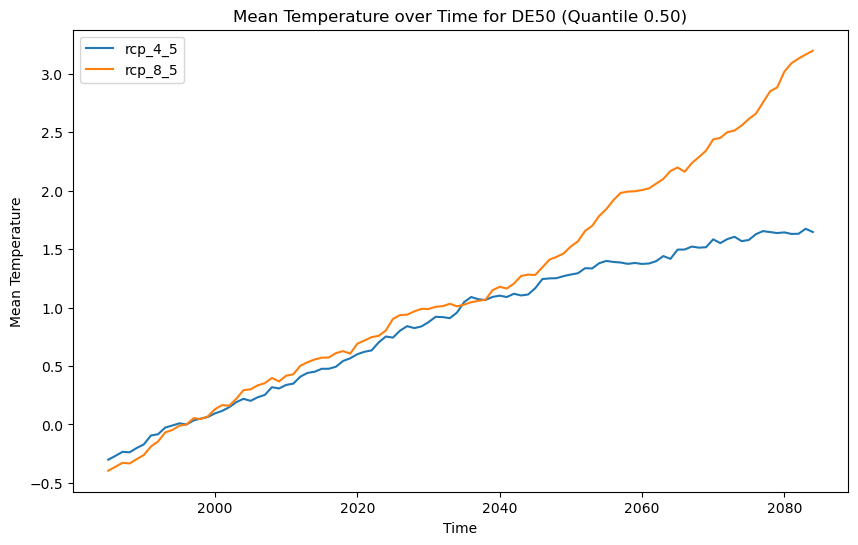

In [14]:
import matplotlib.pyplot as plt

# Filter data for a specific nuts region and quantile
filtered_df = df[(df['nuts'] == 'DE50') & (df['quantile'] == 0.50)]

# Plot mean_temperature over time for each scenario
plt.figure(figsize=(10, 6))
for scenario in filtered_df['scenario'].unique():
    scenario_data = filtered_df[filtered_df['scenario'] == scenario]
    plt.plot(scenario_data['time'], scenario_data['mean_temperature'], label=scenario)

plt.xlabel('Time')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature over Time for DE50 (Quantile 0.50)')
plt.legend()
plt.show()

## (4) Export data to CSV (if needed)

You can select two different servers - greenmonkey or redmonkey

- GREEN_ENGINE_URL
- RED_ENGINE_URL

### (4.1) Specify schema and metadata structures

In [53]:
# Define the sql table name
table_name='nuts2-hot_days-projected-yearly-layer-30yrs_average_change'


## set name of table on server:########################################
schema_name ='ecde'

# Define the column names
columns = ["COLUMN_NAME", "METADATA_INFO", "INFO"]

# Create an empty DataFrame with the specified columns and data type (varchar 255 is equivalent to strings in Python)
data = {
    "COLUMN_NAME": pd.Series(dtype="str"),  # Simulating varchar(255)
    "METADATA_INFO": pd.Series(dtype="str"),
    "INFO": pd.Series(dtype="str"),
}

df_metadata = pd.DataFrame(data)

print(df_metadata)


Empty DataFrame
Columns: [COLUMN_NAME, METADATA_INFO, INFO]
Index: []


PLEASE UPDATE the METADATA:

In [54]:
# Print list of columns with data types
print ("The following list shows all columns inside the table p:")
print ("---------------------------")
i = 1
for col, dtype in df.dtypes.items():
    
    print("Column nr. "+str(i)+ f" - {col}")
    i = i+1

print ("---------------------------")
print ("NEXT please update the metadata info")

The following list shows all columns inside the table p:
---------------------------
Column nr. 1 - nuts
Column nr. 2 - month
Column nr. 3 - avg_period
Column nr. 4 - scenario
Column nr. 5 - height
Column nr. 6 - hot_days_change
---------------------------
NEXT please update the metadata info


In [56]:
# Set metadata information:
#######################################################################################################################
                                                                 # ardeco                                           
m_table_name                  =table_name                                       # population_nuts3_metadata                  
m_metadata_link               ="https://climate-adapt.eea.europa.eu/en/metadata/indicators/hot-days"                                       # link to SDI or other metadata source         
m_cws_file_folder_link        ='P:\Climate\Summer_Product\f02_data\CDS\ECDE_data\nuts_2\06_hot_days'                        # link to folder on CWS \\cwsfileserver\\project           
m_github_link                 ="https://github.com/eea/climate/blob/011d0d34a7980f75d402abd339921ca1810f748a/notebooks/summer_products/tools/tool_04_reading_csv_Eurostat_data_from_CWS.ipynb"                              # link to github https://github.com/eea/climatd             
                                               # free text about the data                           
m_date_publication            ="2025-01-24"                                                                  # 2024-11-15                                           
m_date_creation               ="2025-01-24"                                                            # 2024-11-01                                        
m_contact_person              ="Eva Ivits <Eva.Ivits@eea.europa.eu>"            
m_info                        ="change in nr of hot days above 30deg"                                                # Mara Metadata                                         
#######################################################################################################################


## please update: - please update  - please update - please update - please update - please update 
#Sample data to populate the DataFrame
rows = [
###################################################################### part 1  ()
	('table_name',      ''            ,m_table_name),
	('metadata_link',      '',m_metadata_link),
	('info',        ''          ,	m_info),
	('github_link','',	m_github_link),
	('date_publication','',	m_date_publication),
	('date_creation','',	m_date_creation),
	('cws_file_folder_link','',	m_cws_file_folder_link),
	('contact_person','',	m_contact_person),

###################################################################### part 2 - shoul be updated:




  ('nuts', 'NUTS2', ''),
  ('month', 'all', ''),
  ('avg_period', 'all', ''),
  ('tra_infr', 'update me', ''),
  ('scenario', 'rcp4.5, rcp8.5', ''),
  ('variable', 'change in number of hot days', ''),

]

# Create the DataFrame
df_metadata = pd.DataFrame(rows, columns=columns)

print ("metadata is filled with content")
df_metadata

metadata is filled with content


,COLUMN_NAME,METADATA_INFO,INFO
0,table_name,,nuts2-hot_days-projected-yearly-layer-30yrs_av...
1,metadata_link,,https://climate-adapt.eea.europa.eu/en/metadat...
2,info,,change in nr of hot days above 30deg
3,github_link,,https://github.com/eea/climate/blob/011d0d34a7...
4,date_publication,,2025-01-24
5,date_creation,,2025-01-24
6,cws_file_folder_link,,P:\Climate\Summer_Product 02_data\CDS\ECDE_dat...
7,contact_person,,Eva Ivits <Eva.Ivits@eea.europa.eu>
8,nuts,NUTS2,
9,month,all,


### (4.1) Export dataframe and metadata to SQL

In [57]:
#### EXPORT
#engine_monkey = sa.create_engine(constants.GREEN_ENGINE_URL)   # getting server information from constants!! for greenmonkey
engine_monkey = sa.create_engine(constants.RED_ENGINE_URL)   # getting server information from constants!!    for redmonkey

name_of_table  = table_name
# the following code exported the data frame (test data ) to on of our MS-SQL Server:
df.to_sql(name_of_table, engine_monkey, if_exists='replace', index = False, schema=schema_name)
print ("export done-- table on MS-SQL ready to use")


name_of_meta_table = "metadata-"+name_of_table
# the following code exported the data frame (test data ) to on of our MS-SQL Server:
df_metadata.to_sql(name_of_meta_table, engine_monkey, if_exists='replace', index = False, schema=schema_name)

print ("metadata export done-- table on MS-SQL ready to use")


export done-- table on MS-SQL ready to use
metadata export done-- table on MS-SQL ready to use


In [ ]:
#   ## SETTING:..........................................
#   
#   
#   #indicator ="01_mean_temperature"
#   # indicator ="02_growing_degree_days"
#   # indicator ="03_heating_degree_days"
#   # indicator ="04_cooling_degree_days"
#   # indicator ="05_tropical_nights"
#   # indicator ="06_hot_days"
#   # indicator ="07_warmest_three_day_period"
#   # indicator ="08_heat_waves_health"
#   # indicator ="09_heat_waves_climatological"
#   # indicator ="10_high_utci_days"
#   # indicator ="11_frost_days"
#   # indicator ="12_total_precipitation"
#   # indicator ="13_maximum_five_days_precipitation"
#   # indicator ="14_extreme_precipitation_total"
#   # indicator ="15_frequency_of_extreme_precipitation"
#   # indicator ="16_flood_recurrence_regridded"
#   # indicator ="16b_mean_river_discharge_regridded"
#   # indicator ="17_aridity_actual"
#   indicator ="18_consecutive_dry_days"
#   # indicator ="19_duration_of_meteorological_droughts"
#   # indicator ="20_magnitude_of_meteorological_droughts"
#   # indicator ="21b_mean_soil_moisture"
#   # indicator ="22_days_with_high_fire_danger"
#   # indicator ="23_mean_wind_speed"
#   # indicator ="24_extreme_wind_speed_days"
#   # indicator ="25_snowfall_amount"
#   # indicator ="26_period_with_snow_water_equivalent_above_a_threshold"
#   # indicator ="27_relative_sea_level_rise_gridded"
#   # indicator ="28_extreme_sea_level_gridded"
#   # indicator ="29_sst"
#   # indicator ="30_marine_heatwaves"
#   # indicator ="31_dissolved_oxygen_level"
#   # indicator ="32_ocean_ph_level"
#   # indicator ="l1_daily_maximum_temperature"
#   # indicator ="l2_daily_minimum_temperature"
#   # indicator ="l3_tiger_mosquito_season_length"
#   # indicator ="l4_tiger_mosquito_suitability_index"
#   # indicator ="l6_fire_weather_index"
#   
#   
#   
#   #reference = 'eea_eea_38'
#   # reference = 'eea_eu_27'
#   reference = 'nuts_0'
#   # reference = 'nuts_2'
#   
#   
#   #parameter =   "-historical-yearly-layer-"+reference+"-latitude-1940-2023-v0.1-30yrs_average.nc"
#   
#   parameter =   "-historical-yearly-layer-"+reference+"-latitude-1940-2023-v0.1-anomalies.nc"
#   # parameter = "-projections-seasonal-layer-"+reference+"-latitude-v0.2-30yrs_average.nc"
#   # parameter = "-projections-seasonal-layer-"+reference+"-latitude-v0.2-30yrs_average_change.nc"
#   # parameter = "-projections-yearly-layer-"+reference+"-latitude-v0.2-30yrs_average.nc"
#   # parameter = "-projections-yearly-layer-"+reference+"-latitude-v0.2-30yrs_average_change.nc"
#   # parameter = "-projections-yearly-layer-"+reference+"-latitude-v0.2-anomalies_quantiles_dropna.nc"
#   # parameter = "-projections-yearly-layer-"+reference+"-latitude-v0.2-quantiles_dropna.nc"
#   # parameter = "-historical-seasonal-layer-"+reference+"-latitude-1940-2023-v0.1-30yrs_average.nc"
#   
#   
#   
#   url = "http://ecde-data.service.compute.cci2.ecmwf.int"+"//"+indicator+"//"+"plots"+"//"+indicator+parameter
#   #url = "http://ecde-data.service.compute.cci2.ecmwf.int/18_consecutive_dry_days/plots/18_consecutive_dry_days-historical-seasonal-layer-nuts_0-latitude-1940-2023-v0.1-30yrs_average.nc"
#   
#   
#   print (url)


### (2.3) Downloading multi files

Parmeter:
-----------
- historical-yearly-layer-eea_eea_38-latitude-1940-2023-v0.1-30yrs_average.nc"
- historical-yearly-layer-eea_eea_38-latitude-1940-2023-v0.1-anomalies.nc"
- projections-seasonal-layer-eea_eea_38-latitude-v0.2-30yrs_average.nc"
- projections-seasonal-layer-eea_eea_38-latitude-v0.2-30yrs_average_change.nc"
- projections-yearly-layer-eea_eea_38-latitude-v0.2-30yrs_average.nc"
- projections-yearly-layer-eea_eea_38-latitude-v0.2-30yrs_average_change.nc"
- projections-yearly-layer-eea_eea_38-latitude-v0.2-anomalies_quantiles_dropna.nc"
- projections-yearly-layer-eea_eea_38-latitude-v0.2-quantiles_dropna.nc"
- historical-seasonal-layer-eea_eea_38-latitude-1940-2023-v0.1-30yrs_average.nc"

Folder:
------------------
- eea_eea-38
- eea_eu_27
- nuts_0
- nuts_2


In [ ]:
## SETTING:..........................................

indicator = 'l6_fire_weather_index'

url = "http://ecde-data.service.compute.cci2.ecmwf.int"+"//"+indicator+"//"+"plots"+"//"+indicator+"-historical-seasonal-layer-nuts_0-latitude-1940-2023-v0.1-30yrs_average.nc"

CWS_folder =  r"\\cwsfileserver\projects\Climate\Summer_Product\f02_data\CDS\ECDE_data\download"

print (url)

http://ecde-data.service.compute.cci2.ecmwf.int//l6_fire_weather_index//plots//l6_fire_weather_index-historical-seasonal-layer-nuts_0-latitude-1940-2023-v0.1-30yrs_average.nc


In [ ]:


# # URL of the directory
# base_url = "http://ecde-data.service.compute.cci2.ecmwf.int/18_consecutive_dry_days/plots/"# 

# # Send a request to the directory URL
# response = requests.get(base_url)
# response.raise_for_status()  # Check if the request was successful# 

# # Parse the HTML content
# soup = BeautifulSoup(response.text, 'html.parser')# 

# # Find all links to .nc files in the directory
# nc_files = [base_url + link.get('href') for link in soup.find_all('a') if link.get('href').endswith('.nc')]# 

# # Download each .nc file
# for nc_file in nc_files:
#     filename = os.path.basename(nc_file)
#     print(f"Downloading {filename}...")
#     try:
#         file_response = requests.get(nc_file)
#         file_response.raise_for_status()
#         with open(filename, "wb") as f:
#             f.write(file_response.content)
#         print(f"Downloaded {filename}")
#     except Exception as e:
#         print(f"Failed to download {filename}: {e}")# 
